# Emotion detection for facial expressions

In [16]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import pandas as pd
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader, random_split
from torchvision import transforms
import torch.optim as optim
from torch import nn
torch.manual_seed(123)
from IPython.display import clear_output
from typing import cast

# Loading the dataset

In [7]:
df = pd.read_csv('fer2013.csv')

class FER2013Dataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        #Load pixels and labels from csv
        pixels = self.dataframe.iloc[idx, 1]
        label = int(self.dataframe.iloc[idx, 0])

        # Convert to 48x48 pixel image
        image = np.fromstring(pixels, sep=' ').reshape(48, 48).astype(np.uint8)

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformation
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Create dataset
fer_dataset = FER2013Dataset(dataframe=df, transform=transform)

# Split in Training (80%), Validation (10%) and Test (10%)
train_size = int(0.8 * len(fer_dataset))
val_size = int(0.1 * len(fer_dataset))
test_size = len(fer_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(fer_dataset, [train_size, val_size, test_size])

# Create dataloader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



## Implementing the network

In [8]:

class NormedConv2d(nn.Conv2d):
    """
    Standard 2D convolution, but with unit norm weights.
    """

    def forward(self, in_tensor):
        shape = self.weight.shape
        w = self.weight.view(shape[0], -1)
        w = w/(w.norm(p=2, dim=1, keepdim=True))
        return F.conv2d(in_tensor, w.view(shape),
                        self.bias, self.stride, self.padding, self.dilation, self.groups)

class BcosConv2d(nn.Module):

    def __init__(self, inc, outc, kernel_size=1, stride=1, padding=0, max_out=2, b=2,
                 scale=None, scale_fact=100, **kwargs):
        super().__init__()
        
        ks = kernel_size
        self.stride = stride
        self.linear = NormedConv2d(inc, outc * max_out, ks, stride, padding, 1, 1, bias=False)
        self.outc = outc * max_out
        self.b = b
        self.max_out = max_out
        self.inc = inc
        self.kernel_size = ks
        self.kssq = ks**2 if not isinstance(ks, tuple) else np.prod(ks)
        self.padding = padding
        self.detach = False
        if scale is None:
            ks_scale = ks if not isinstance(ks, tuple) else np.sqrt(np.prod(ks))
            self.scale = (ks_scale * np.sqrt(self.inc)) / scale_fact
        else:
            self.scale = scale

    def forward(self, in_tensor):
        """
        In the case of B=2, we do not have to explicitly calculate the cosine term.
        Args:
            in_tensor: Input tensor. Expected shape: (B, C, H, W)

        Returns:
            BcosConv2d output on the input tensor.
        """
        if self.b == 2:
            return self.fwd_2(in_tensor)
        return self.fwd_b(in_tensor)

    def explanation_mode(self, detach=True):
        """
        Enter 'explanation mode' by setting self.explain and self.detach.
        Args:
            detach: Whether to 'detach' the weight matrix from the computational graph so that it is not
                            taken into account in the backward pass.

        Returns: None

        """
        self.detach = detach

    def fwd_b(self, in_tensor):
        # Simple linear layer
        out = self.linear(in_tensor)
        bs, _, h, w = out.shape

        # MaxOut computation
        if self.max_out > 1:
            bs, _, h, w = out.shape
            out = out.view(bs, -1, self.max_out, h, w)
            out = out.max(dim=2, keepdim=False)[0]

        # If B=1, no further calculation necessary.
        if self.b == 1:
            return out / self.scale

        # Calculating the norm of input patches. Use average pooling and upscale by kernel size.
        norm = (F.avg_pool2d((in_tensor ** 2).sum(1, keepdim=True), self.kernel_size, padding=self.padding,
                             stride=self.stride) * self.kssq + 1e-6  # stabilising term
                ).sqrt_()

        # get absolute value of cos
        # TODO: unnecessary doubling of stabilising term. Only affects CIFAR10 experiments in the paper.
        abs_cos = (out / norm).abs() + 1e-6

        # In order to compute the explanations, we detach the dynamically calculated scaling from the graph.
        if self.detach:
            abs_cos = abs_cos.detach()

        # additional factor of cos^(b-1) s.t. in total we have norm * cos^b with original sign
        out = out * abs_cos.pow(self.b-1)
        return out / self.scale

    def fwd_2(self, in_tensor):
        # Simple linear layer
        out = self.linear(in_tensor)

        # MaxOut computation
        if self.max_out > 1:
            bs, _, h, w = out.shape
            out = out.view(bs, -1, self.max_out, h, w)
            out = out.max(dim=2, keepdim=False)[0]

        # Calculating the norm of input patches. Use average pooling and upscale by kernel size.
        # TODO: implement directly as F.sum_pool2d...
        norm = (F.avg_pool2d((in_tensor ** 2).sum(1, keepdim=True), self.kernel_size, padding=self.padding,
                                    stride=self.stride) * self.kssq + 1e-6  # stabilising term
                ).sqrt_()

        # In order to compute the explanations, we detach the dynamically calculated scaling from the graph.
        if self.detach:
            out = (out * out.abs().detach())
            norm = norm.detach()
        else:
            out = (out * out.abs())

        return out / (norm * self.scale)

                


In [71]:
def make_layers() -> nn.Sequential:
    layers: List[nn.Module] = []
    in_channels = 1
    #cfg=[64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']#VGG11 Architec
    cfg=[16, 'M', 32, 'M', 64,'M',64, 'M']
    for v in cfg:
        if v == 'M':
            layers += [nn.AvgPool2d(kernel_size=2, stride=2)]
        else:
            v=cast(int,v)
            conv2d = BcosConv2d(in_channels, v, kernel_size=3, padding=1, stride=1, scale_fact=1000)
            layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)



class VGG(nn.Module):

    def __init__(
        self,
    ) -> None:
        super(VGG, self).__init__()
        self.num_classes:int=7
        self.features = make_layers()
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            BcosConv2d(64, 1024, kernel_size=7, padding=3, scale_fact=1000),
            BcosConv2d(1024, 1024, scale_fact=1000),
            BcosConv2d(1024, self.num_classes, scale_fact=1000),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.classifier(x)
        return x

    def get_features(self, x):
        return self.features(x)

    def get_sequential_model(self):
        model = nn.Sequential(
            *[m for m in self.features], self.classifier
        )
        return model

    def get_layer_idx(self, idx):
        return int(np.ceil(len(self.get_sequential_model())*idx/10))

In [72]:


# Cosine similarity-based loss function
def cosine_loss(outputs, labels):
    labels_one_hot = F.one_hot(labels, num_classes=outputs.size(1)).float()
    cosine_sim = F.cosine_similarity(outputs, labels_one_hot, dim=1)
    loss = 1 - torch.mean(cosine_sim)  # Use cosine similarity as loss
    return loss

# Validation function with cosine accuracy
def validate(model, val_loader):
    model.eval()
    val_loss = 0.0
    cosine_acc = 0.0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = cosine_loss(outputs, labels)
            val_loss += loss.item()
            cosine_acc += cosine_accuracy(outputs, labels)
            total += labels.size(0)
    return val_loss / len(val_loader), cosine_acc / len(val_loader)

# Cosine accuracy calculation
def cosine_accuracy(outputs, labels):
    labels_one_hot = F.one_hot(labels, num_classes=outputs.size(1)).float()
    cosine_sim = F.cosine_similarity(outputs, labels_one_hot, dim=1)
    correct = torch.sum(cosine_sim > 0.5).item()
    total = labels.size(0)
    accuracy = correct / total
    return accuracy



## Define training and validation

## Training the network

In [73]:
def model_selection_and_evaluation(models, train_loader, val_loader,n_epochs):
    plt.ion()  # Interaktiver Modus aktivieren

    best_model = None
    best_accuracy = 0
    results = []
    for epoch in range(n_epochs):
        for i, (model_name, model) in enumerate(models.items()):
            print(f"\nTraining {model_name}...")
            model = model.to(device)
        
        
            optimizer = optim.SGD(model.parameters(), lr=0.01,nesterov=True,momentum=0.9,weight_decay=1e-4)
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.75, patience=5, verbose=True)
            # Train model
            model.train()  
            optimizer.zero_grad(set_to_none=True)  #set gradients to zero
        
        
            running_loss = 0.0

            # Training
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

            
                outputs= model(images)  # Foreward pass
                print(outputs.shape)
                print(labels.shape)
                loss = nn.CrossEntropyLoss(outputs, labels)  # Calculate loss, muss noch durch cosine loss ersetzt werden
                loss.backward()  # Back pass
                optimizer.step()  # update parameters
                optimizer.zero_grad()
                running_loss += loss.item()

            # Calculate loss and accuracy for the validation data
            val_loss, val_accuracy = validate(model, val_loader)
            scheduler.step(val_loss)
            print(f"Epoch [{epoch+1}/{n_epochs}],model name {model_name} Loss: {running_loss/len(train_loader):.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
        
            # Evaluate model

            results.append((model_name, val_accuracy))

            # Select best model
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_model = model
        

        model_dict = {}
        for model, accuracy in results:
            if model not in model_dict:
                model_dict[model] = []  # Create a list for each model
            model_dict[model].append(accuracy)
        plt.figure(figsize=(10, 6))

    
        clear_output(wait=True)
        for model, accuracies in model_dict.items():
            plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o', label=model)
        
        # Achsen und Titel
        plt.title('Validation accuracy as a function of number of epochs for all models')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        plt.show()
        plt.savefig("accuracy.png")
    print("\nModell comparison:")
    for model_name, accuracy in results:
        print(f"{model_name}: {accuracy:.2f}%")
    plt.ioff()  # Interaktiven Modus deaktivieren
    plt.show()  # Plot am Ende anzeigen
    return best_model, best_accuracy

In [74]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device {device}.")
n_epochs=20
#Put in here the models you want to train
models = {
   "Bcos LeNet5:":VGG(),
   
}

best_model, best_accuracy = model_selection_and_evaluation(models, train_loader, val_loader,n_epochs)
_,test_accuracy=validate(best_model, test_loader)*100.
print(f"\nBest model: {best_model.__class__.__name__} with a test accuracy of {test_accuracy:.2f}%")

Training on device cpu.

Training Bcos LeNet5:...


c:\Users\arnel\pyver\py3123\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


torch.Size([32, 7, 3, 3])
torch.Size([32])


RuntimeError: Boolean value of Tensor with more than one value is ambiguous

Bilder: torch.Size([32, 1, 48, 48])
Labels: tensor([4, 5, 2, 3, 3, 3, 3, 0, 2, 3, 5, 3, 6, 5, 6, 2, 3, 6, 6, 6, 0, 3, 0, 3,
        4, 3, 0, 3, 3, 2, 6, 1])


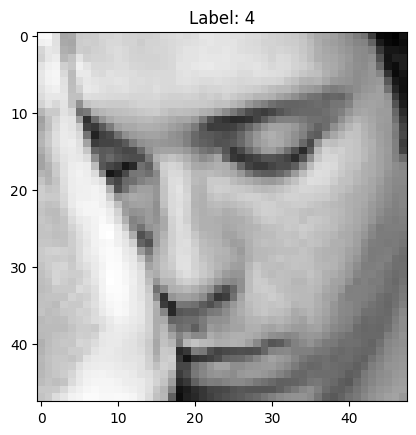

In [ ]:
# Example: Load a batch and plot an image
data_iter = iter(train_loader)
images, labels = next(data_iter)

print(f"Bilder: {images.shape}")
print(f"Labels: {labels}")

plt.imshow(images[0].squeeze(), cmap="gray")
plt.title(f"Label: {labels[0].item()}")
plt.show()

In [79]:
dic_label={0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

In [81]:
emotion=dic_label[int(best_model(images[0]).argmax())]

In [94]:
img=models["Bcos LeNet5:"].cos_sim1
img=img.detach().numpy()
img.shape

(1, 120)